<a href="https://colab.research.google.com/github/VGGatGitHub/CohortProject_2020_week1/blob/master/Task1_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task #1 

A template code for training an RBM on H$_2$ data for $r = 1.2$ is shown here. Modify this!

Imports and loading in data:

In [ ]:
!git clone https://github.com/VGGatGitHub/CohortProject_2020_week1.git

fatal: destination path 'CohortProject_2020_week1' already exists and is not an empty directory.


In [ ]:
!pwd
!ls
f_loc="/content/CohortProject_2020_week1/Project_1_RBM_and_Tomography/"

/content
CohortProject_2020_week1  sample_data


In [ ]:
import sys
sys.path.append(f_loc)

import os
print(os.getcwd())

r_list=[]
for dirname, _, filenames in os.walk(f_loc+"./H2_data/"):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        i1=filename.find("R_")
        i2=filename.find("_s")
        if i2-i1>2:
          #print(os.path.join(filename))
          r_list.append(filename[i1+2:i2])

/content


In [ ]:
r_list[0:10]

['2.0', '1.1', '1.15', '1.2', '2.45', '2.85', '2.05', '0.5', '1.8', '1.65']

In [ ]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline

from RBM_helper import RBM

import H2_energy_calculator


In [ ]:
coefficients = np.loadtxt(f_loc+"H2_data/H2_coefficients.txt")
coeff=coefficients[20,:]
r=coeff[0]

training_data = torch.from_numpy(np.loadtxt(f_loc+"H2_data/R_"+str(r)+"_samples.txt"))
true_energy = H2_energy_calculator.energy_from_freq(training_data, coeff)
print("H2 energy for r = ",r," :",true_energy)

H2 energy for r =  1.2  : -1.0642022250418146


In [ ]:
len(r_list)

54

In [ ]:
len(coefficients)

54

In [ ]:
coeff


array([ 1.2   , -0.1253,  0.2374, -0.1603,  0.4892,  0.105 ,  0.105 ,
        5.9509])

In [ ]:
training_data.detach().numpy().shape

(10000, 2)

Define the RBM:

In [ ]:
rs=[]
for i in range(len(coefficients)):
  coeff=coefficients[i,:]
  r=coeff[0]
  rs.append(r)

In [ ]:
n_vis = 2
n_hin = 10

start_time = time.time()
%time rbm = RBM(n_vis, n_hin)
print("time {:.2f} sec".format((time.time()-start_time)))

CPU times: user 563 µs, sys: 0 ns, total: 563 µs
Wall time: 1.01 ms
time 0.00 sec


Train the RBMs by using the preivius r-point Weights and break out when under 1% of the exact result.

---



In [ ]:
%%time
epochs = 500 # number of training steps
num_samples = 200 # number of samples to generate from the RBM to calculate the H2 energy
printing=100 # when to print intermidiate results

E_min=0.0
saved_weights = []

rs=[]
true_energies=[]
computed_Es=[]
cmpted_Es=np.empty((epochs//printing,len(coefficients)))

for i in range(len(coefficients)-1,-1,-1):
  coeff=coefficients[i,:]
  r=coeff[0]
  rs.append(r)
  #rbm = RBM(n_vis, n_hin)

  training_data = torch.from_numpy(np.loadtxt(f_loc+"H2_data/R_"+str(r)+"_samples.txt"))
  true_energy = H2_energy_calculator.energy_from_freq(training_data, coeff)

  true_energies.append(true_energy)
  #print("H2 energy for r =\t",r,"\t:",true_energy)
  
  start_time = time.time()

  for epoch in range(1, epochs+1):
      # do one epoch of training
      lr = (0.1*np.exp(-epoch/epochs*10))+0.0001
      rbm.train(training_data,lr = lr)   
  
      # now generate samples and calculate the energy
      if epoch % printing == 0:
          #print("\nEpoch: ", e)
          #print("Sampling the RBM...")

          # For sampling the RBM, we need to do Gibbs sampling.
          # Initialize the Gibbs sampling chain with init_state as defined below.
          init_state = torch.zeros(num_samples, n_vis)
          RBM_samples = rbm.draw_samples(15, init_state)

          #print("Done sampling. Calculating energy...")       
  
          energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction)
          #print("Energy from RBM samples: ", energies.item())
  
          cmpted_Es[e//printing-1,i]=energies.item()
      
      init_state = torch.zeros(num_samples, n_vis)
      RBM_samples = rbm.draw_samples(num_samples, init_state)
      energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction)
      RBM_energy = energies.item()

      if 100*abs(1-RBM_energy/true_energy) < .9:
        break

  energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction)
  RBM_energy = energies.item()
  computed_Es.append(RBM_energy)
  print("H2 energy for r ={:6.3f}, E={:7.3f}, E_rmb={:7.3f}, diff:{:5.1f}%, epohs:{:4d}, time:{:.2f} sec.".format(
      r,true_energy,RBM_energy,100*abs(1-RBM_energy/true_energy),epoch,(time.time()-start_time)))

  if E_min > RBM_energy:
    E_min = RBM_energy
    j_min=len(coefficients)-1-i
    r_min=r

  saved_weights.append([i,r,RBM_energy])
  
  tmp=np.zeros((n_hin,n_vis))
  tmp+=rbm.weights.detach().numpy()
  saved_weights.append(tmp)
  
  tmp=np.zeros(n_vis)
  tmp+=rbm.visible_bias.detach().numpy()
  saved_weights.append(tmp)

  tmp=np.zeros(n_hin)
  tmp+=rbm.hidden_bias.detach().numpy()
  saved_weights.append(tmp)


H2 energy for r = 2.850, E= -0.943, E_rmb= -0.938, diff:  0.5%, epohs:  19, time:2.78 sec.
H2 energy for r = 2.800, E= -0.943, E_rmb= -0.935, diff:  0.9%, epohs:   4, time:0.60 sec.
H2 energy for r = 2.750, E= -0.943, E_rmb= -0.943, diff:  0.0%, epohs:   3, time:0.45 sec.
H2 energy for r = 2.700, E= -0.944, E_rmb= -0.938, diff:  0.6%, epohs:   1, time:0.16 sec.
H2 energy for r = 2.650, E= -0.944, E_rmb= -0.939, diff:  0.6%, epohs:   2, time:0.31 sec.
H2 energy for r = 2.600, E= -0.944, E_rmb= -0.945, diff:  0.1%, epohs:   1, time:0.17 sec.
H2 energy for r = 2.550, E= -0.945, E_rmb= -0.941, diff:  0.4%, epohs:   2, time:0.33 sec.
H2 energy for r = 2.500, E= -0.945, E_rmb= -0.945, diff:  0.0%, epohs:   1, time:0.17 sec.
H2 energy for r = 2.450, E= -0.945, E_rmb= -0.937, diff:  0.8%, epohs:   1, time:0.17 sec.
H2 energy for r = 2.400, E= -0.946, E_rmb= -0.946, diff:  0.0%, epohs:   1, time:0.17 sec.
H2 energy for r = 2.350, E= -0.947, E_rmb= -0.947, diff:  0.0%, epohs:   2, time:0.31 sec.

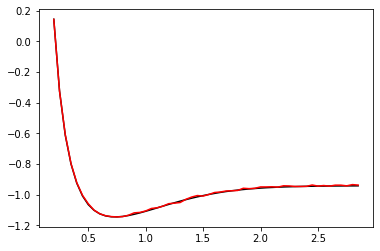

In [ ]:
#plt.xlim(-2, 2)
#plt.ylim(0, 1.1)
plt.plot(rs, true_energies,'k')
plt.plot(rs, computed_Es,'r')

In [ ]:
j_min

42

In [ ]:
saved_weights[4*(j_min)]

[11, 0.75, -1.1457876562007312]

Use the RMB at the minimum to compute the energy curve.

In [ ]:
rbm = RBM(n_vis, n_hin)

#Use the weights from the minimum 
ii=4*(j_min-13)
i=saved_weights[ii][0]
r=saved_weights[ii][1]
rbm.weights=torch.from_numpy(saved_weights[ii+1])
rbm.visible_bias=torch.from_numpy(saved_weights[ii+2])
rbm.hidden_bias=torch.from_numpy(saved_weights[ii+3])

coeff=coefficients[i,:]
r=coeff[0]
if abs(r-coeff[0]) > 10**(-2):
  print(r,coeff[0])

num_samples = 1000 # number of samples to generate from the RBM to calculate the H2 energy

rs=[] #lets do the r values again
true_energies=[]
rbm_Es=[]

for i in range(len(coefficients)):
  coeff=coefficients[i,:]
  r=coeff[0]
  rs.append(r)

  in_data=np.loadtxt(f_loc+"H2_data/R_"+str(r)+"_samples.txt")
  all_in_data = torch.from_numpy(in_data)
  true_energy = H2_energy_calculator.energy_from_freq(all_in_data, coeff)
  true_energies.append(true_energy)

  # For sampling the RBM, we need to do Gibbs sampling.
  # Initialize the Gibbs sampling chain with init_state as the input.
  init_state = torch.zeros(num_samples, n_vis)
  #init_state = torch.from_numpy(in_data[0:num_samples,:])
  RBM_samples = rbm.draw_samples(num_samples, init_state)
  energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction)
  RBM_energy = energies.item()

  rbm_Es.append(RBM_energy)
  print("H2 energy for r ={:6.3f}, E={:7.3f}, E_rmb={:7.3f}, diff:{:5.1f}%".format(
      r,true_energy,RBM_energy,100*abs(1-RBM_energy/true_energy)))


H2 energy for r = 0.200, E=  0.144, E_rmb=  0.404, diff:180.1%
H2 energy for r = 0.250, E= -0.324, E_rmb= -0.051, diff: 84.2%
H2 energy for r = 0.300, E= -0.613, E_rmb= -0.427, diff: 30.4%
H2 energy for r = 0.350, E= -0.801, E_rmb= -0.590, diff: 26.3%
H2 energy for r = 0.400, E= -0.925, E_rmb= -0.767, diff: 17.1%
H2 energy for r = 0.450, E= -1.009, E_rmb= -0.889, diff: 11.9%
H2 energy for r = 0.500, E= -1.065, E_rmb= -0.904, diff: 15.1%
H2 energy for r = 0.550, E= -1.102, E_rmb= -0.976, diff: 11.4%
H2 energy for r = 0.600, E= -1.126, E_rmb= -1.012, diff: 10.1%
H2 energy for r = 0.650, E= -1.139, E_rmb= -1.061, diff:  6.9%
H2 energy for r = 0.700, E= -1.145, E_rmb= -1.084, diff:  5.3%
H2 energy for r = 0.750, E= -1.146, E_rmb= -1.088, diff:  5.0%
H2 energy for r = 0.800, E= -1.143, E_rmb= -1.086, diff:  4.9%
H2 energy for r = 0.850, E= -1.137, E_rmb= -1.095, diff:  3.7%
H2 energy for r = 0.900, E= -1.129, E_rmb= -1.082, diff:  4.1%
H2 energy for r = 0.950, E= -1.119, E_rmb= -1.093, diff

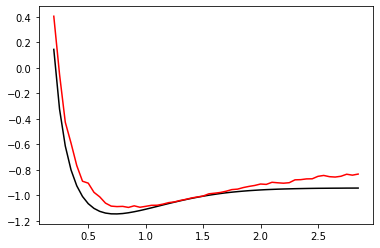

In [ ]:
#plt.xlim(-2, 2)
#plt.ylim(0, 1.1)
plt.plot(rs, true_energies,'k')
plt.plot(rs, rbm_Es,'r')

In [ ]:
%%time
epochs = 190 # number of training steps
num_samples = 500 # number of samples to generate from the RBM to calculate the H2 energy
printing=40 # when to print intermidiate results

rs=[]
true_energies=[]
computed_Es=[]
cmpted_Es=np.empty((epochs//printing,len(coefficients)))

for i in range(len(coefficients)):
  coeff=coefficients[i,:]
  r=coeff[0]
  rs.append(r)
  rbm = RBM(n_vis, n_hin)

  training_data = torch.from_numpy(np.loadtxt(f_loc+"H2_data/R_"+str(r)+"_samples.txt"))
  true_energy = H2_energy_calculator.energy_from_freq(training_data, coeff)

  true_energies.append(true_energy)
  #print("H2 energy for r =\t",r,"\t:",true_energy)
  
  start_time = time.time()

  for epoch in range(1, epochs+1):
      # do one epoch of training
      lr = (0.1*np.exp(-epoch/epochs*10))+0.0001
      rbm.train(training_data,lr = lr)   
  
      # now generate samples and calculate the energy
      if epoch % printing == 0:
          #print("\nEpoch: ", e)
          #print("Sampling the RBM...")

          # For sampling the RBM, we need to do Gibbs sampling.
          # Initialize the Gibbs sampling chain with init_state as defined below.
          init_state = torch.zeros(num_samples, n_vis)
          RBM_samples = rbm.draw_samples(15, init_state)

          #print("Done sampling. Calculating energy...")       
  
          energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction)
          #print("Energy from RBM samples: ", energies.item())
  
          cmpted_Es[epoch//printing-1,i]=energies.item()
      
      init_state = torch.zeros(num_samples, n_vis)
      RBM_samples = rbm.draw_samples(num_samples, init_state)
      energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction)
      RBM_energy = energies.item()
      if 100*abs(1-RBM_energy/true_energy) < 0.9:
        #break #VGG keep on going 
        pass
  
  energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction)
  RBM_energy = energies.item()
  computed_Es.append(RBM_energy)
  print("H2 energy for r ={:6.3f}, E={:7.3f}, E_rmb={:7.3f}, diff:{:5.1f}%, epohs:{:}, time:{:.2f} sec.".format(
      r,true_energy,RBM_energy,100*abs(1-RBM_energy/true_energy),epoch,(time.time()-start_time)))



H2 energy for r = 0.200, E=  0.144, E_rmb=  0.150, diff:  3.9%, epohs:190, time:50.76 sec.
H2 energy for r = 0.250, E= -0.324, E_rmb= -0.289, diff: 10.7%, epohs:190, time:51.11 sec.
H2 energy for r = 0.300, E= -0.613, E_rmb= -0.594, diff:  3.1%, epohs:190, time:50.89 sec.
H2 energy for r = 0.350, E= -0.801, E_rmb= -0.779, diff:  2.7%, epohs:190, time:50.59 sec.
H2 energy for r = 0.400, E= -0.925, E_rmb= -0.894, diff:  3.4%, epohs:190, time:51.33 sec.
H2 energy for r = 0.450, E= -1.009, E_rmb= -0.985, diff:  2.4%, epohs:190, time:50.17 sec.
H2 energy for r = 0.500, E= -1.065, E_rmb= -1.021, diff:  4.1%, epohs:190, time:55.47 sec.
H2 energy for r = 0.550, E= -1.102, E_rmb= -1.077, diff:  2.3%, epohs:190, time:51.34 sec.
H2 energy for r = 0.600, E= -1.126, E_rmb= -1.097, diff:  2.5%, epohs:190, time:50.84 sec.
H2 energy for r = 0.650, E= -1.139, E_rmb= -1.108, diff:  2.7%, epohs:190, time:50.77 sec.
H2 energy for r = 0.700, E= -1.145, E_rmb= -1.114, diff:  2.7%, epohs:190, time:50.58 sec.

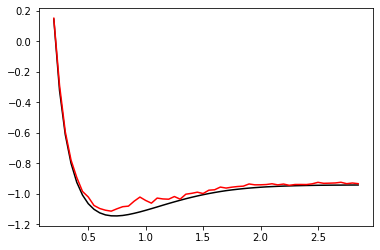

In [ ]:
plt.plot(rs, true_energies,'k')
plt.plot(rs, computed_Es,'r')


In [ ]:
epochs//printing

4

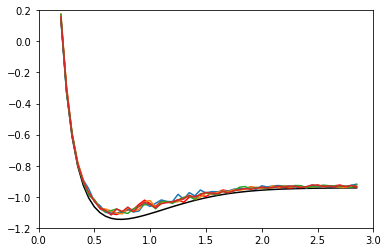

In [ ]:
plt.xlim(0, 3)
plt.ylim(-1.2, 0.2)
plt.plot(rs, true_energies,'k')
plt.plot(rs, computed_Es,'r')
for i in range(epochs//printing):
  plt.plot(rs, cmpted_Es[i,:])
